In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_files    
from keras.preprocessing import image     
from tqdm import tqdm
from PIL import Image

import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

import numpy as np




/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


# Problems
- Accuracy is good but no better than guess all one class. Think this could be solved by addressing class imbalance
- Accuracy is only good if we take the binary crossentropy and not the full label accuracy. Will need to speak to the lecturer about how to measure performance for this type of multilabel data. 

# TODO
- Need to balance the classes before passing them into the model. I.e. we need to take in more data to get a 50 50 split between having a disease and not, then run through the model. This should be possible as currently we're only processing 1% of the data. 10% is without any disease so that;s 20k. We then use another 20k with a disease. 
- Also need to add the gender and age into the x train so the model can use this information as well as the image. 
- May want to pass the data into a high res image generator or use the high res images, which would require using the GPU servers
- To allow a more complex model to learn quickly on the gpu servers, may want to try using transfer learning from an existing model

In [2]:
rawDf = pd.read_csv('CheXpert-v1.0-small/train.csv')

# Remove anomalous dataline
rawDf = rawDf[rawDf.Sex != 'Unknown']
# Drop this column as it has many more classifications than lit suggests and shouldn't matter greatly for a CNN
# TODO try with and without this column
rawDf = rawDf.drop('AP/PA', 1)

def pathToID(path):
    pathList = path.split('/')
    return pathList[2][7:]

def pathToStudy(path):
    pathList = path.split('/')
    return pathList[3][5:]

rawDf = rawDf.fillna(-1)
agebackup = rawDf['Age']
rawDf = rawDf.replace(1,'true')
rawDf = rawDf.replace(0,'unknown')
rawDf = rawDf.replace(-1,'false')
rawDf['Age'] = agebackup
del agebackup

# Convert all labels to a series of one-hot encoded labels. 
trainDf = pd.get_dummies(rawDf.iloc[:,1:18])
trainDf.insert(0,'Path', rawDf['Path'])
trainDf.insert(0,'Study',trainDf.Path.apply(pathToStudy))
trainDf.insert(0,'Patient ID',trainDf.Path.apply(pathToID))

print(trainDf.columns)


Index(['Patient ID', 'Study', 'Path', 'Age', 'Sex_Female', 'Sex_Male',
       'Frontal/Lateral_Frontal', 'Frontal/Lateral_Lateral',
       'No Finding_false', 'No Finding_true',
       'Enlarged Cardiomediastinum_false', 'Enlarged Cardiomediastinum_true',
       'Enlarged Cardiomediastinum_unknown', 'Cardiomegaly_false',
       'Cardiomegaly_true', 'Cardiomegaly_unknown', 'Lung Opacity_false',
       'Lung Opacity_true', 'Lung Opacity_unknown', 'Lung Lesion_false',
       'Lung Lesion_true', 'Lung Lesion_unknown', 'Edema_false', 'Edema_true',
       'Edema_unknown', 'Consolidation_false', 'Consolidation_true',
       'Consolidation_unknown', 'Pneumonia_false', 'Pneumonia_true',
       'Pneumonia_unknown', 'Atelectasis_false', 'Atelectasis_true',
       'Atelectasis_unknown', 'Pneumothorax_false', 'Pneumothorax_true',
       'Pneumothorax_unknown', 'Pleural Effusion_false',
       'Pleural Effusion_true', 'Pleural Effusion_unknown',
       'Pleural Other_false', 'Pleural Other_true', 'P

# Preliminary Analysis

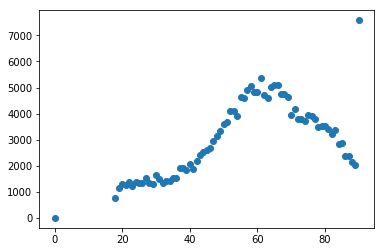

In [3]:
# Shows age distribution of the data set. There are 3 0-olds and 7579 90 year olds. 
# Implies that over nineties were grouped together
ages = trainDf['Age'].value_counts()
plt.scatter(ages.keys(),ages.values)

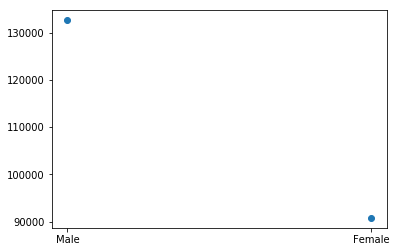

In [4]:
gender = rawDf['Sex'].value_counts()
plt.scatter(gender.keys(),gender.values)

false    201033
true      22380
Name: No Finding, dtype: int64


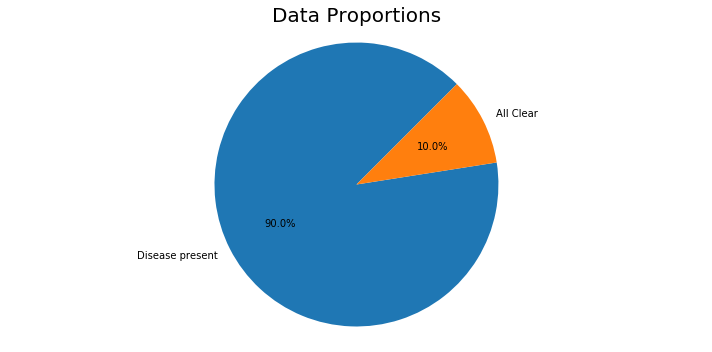

In [5]:
# How many people have no disease?
no_finding = rawDf['No Finding'].value_counts()
print(no_finding)

# Plot pie chart to show how much of the data is labelled with each character
values = no_finding.values
labels = ['Disease present','All Clear']

# Plot
plt.figure(figsize=(10, 5))
plt.title('Data Proportions', size=20)
plt.pie(values, labels=labels, # explode=explode,
        autopct='%1.1f%%', shadow=False, startangle=45)
 
plt.axis('equal')
plt.tight_layout()
plt.show()



In [4]:
trainDf

,Patient ID,Study,Path,Age,Sex_Female,Sex_Male,Frontal/Lateral_Frontal,Frontal/Lateral_Lateral,No Finding_false,No Finding_true,...,Pleural Effusion_unknown,Pleural Other_false,Pleural Other_true,Pleural Other_unknown,Fracture_false,Fracture_true,Fracture_unknown,Support Devices_false,Support Devices_true,Support Devices_unknown
0,00001,1,CheXpert-v1.0-small/train/patient00001/study1/...,68,1,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
1,00002,2,CheXpert-v1.0-small/train/patient00002/study2/...,87,1,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
2,00002,1,CheXpert-v1.0-small/train/patient00002/study1/...,83,1,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
3,00002,1,CheXpert-v1.0-small/train/patient00002/study1/...,83,1,0,0,1,1,0,...,0,1,0,0,0,1,0,1,0,0
4,00003,1,CheXpert-v1.0-small/train/patient00003/study1/...,41,0,1,1,0,1,0,...,0,1,0,0,1,0,0,1,0,0
5,00004,1,CheXpert-v1.0-small/train/patient00004/study1/...,20,1,0,1,0,0,1,...,1,1,0,0,1,0,0,1,0,0
6,00004,1,CheXpert-v1.0-small/train/patient00004/study1/...,20,1,0,0,1,0,1,...,1,1,0,0,1,0,0,1,0,0
7,00005,1,CheXpert-v1.0-small/train/patient00005/study1/...,33,0,1,1,0,0,1,...,1,1,0,0,1,0,0,0,1,0
8,00005,1,CheXpert-v1.0-small/train/patient00005/study1/...,33,0,1,0,1,0,1,...,1,1,0,0,1,0,0,0,1,0
9,00005,2,CheXpert-v1.0-small/train/patient00005/study2/...,33,0,1,1,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [3]:
img_paths = trainDf['Path'].tolist()
inputSize = (150,150)
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    return files


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, color_mode = "grayscale", target_size=inputSize)
    # convert PIL.Image.Image type to 3D tensor with shape (x, x, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [16]:
training_no = 2000
val_no = 2000
x_train = paths_to_tensor(img_paths[:training_no]).astype('float32')/255
y_train = trainDf.iloc[:training_no,10:13] # to do all labels: trainDf.iloc[:training_no,8:]
x_val = paths_to_tensor(img_paths[training_no:training_no+val_no]).astype('float32')/255
y_val = trainDf.iloc[training_no:training_no+val_no,10:13]

print(y_train.columns)

Index(['Enlarged Cardiomediastinum_false', 'Enlarged Cardiomediastinum_true',
       'Enlarged Cardiomediastinum_unknown'],
      dtype='object')


In [17]:


model = Sequential()

model.add(Conv2D(64, (6,6), strides=(3,3), input_shape=(inputSize[0],inputSize[1],1)))
model.add(Conv2D(32, (5,5)))
#model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))



model.add(Dense(len(y_train.columns), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
weightsFilePath="weights.best.hdf5"

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 49, 49, 64)        2368      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 45, 45, 32)        51232     
_________________________________________________________________
flatten_5 (Flatten)          (None, 64800)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64800)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4147264   
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
__________

In [22]:
label_counts = y_train['Enlarged Cardiomediastinum_true'].value_counts().tolist()
# Basic model accuracy to beat for findings:
print(label_counts[0] / (label_counts[0] + label_counts[1]))

0.955


In [18]:
checkpoint = ModelCheckpoint(weightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit(x_train,y_train, epochs = 30, batch_size=16, validation_data=(x_val, y_val), callbacks=[checkpoint])
model.load_weights(weightsFilePath)


Train on 2000 samples, validate on 2000 samples
Epoch 1/30
2000/2000 [==============================] - 9s 4ms/step - loss: 0.7086 - acc: 0.7940 - val_loss: 0.5113 - val_acc: 0.8520

Epoch 00001: val_acc improved from -inf to 0.85200, saving model to weights.best.hdf5
Epoch 2/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.6750 - acc: 0.8250 - val_loss: 0.5012 - val_acc: 0.8520

Epoch 00002: val_acc did not improve from 0.85200
Epoch 3/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.6241 - acc: 0.8305 - val_loss: 0.5128 - val_acc: 0.8520

Epoch 00003: val_acc did not improve from 0.85200
Epoch 4/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.6061 - acc: 0.8310 - val_loss: 0.5159 - val_acc: 0.8520

Epoch 00004: val_acc did not improve from 0.85200
Epoch 5/30
2000/2000 [==============================] - 9s 4ms/step - loss: 0.5561 - acc: 0.8330 - val_loss: 0.5109 - val_acc: 0.8520

Epoch 00005: val_acc did not improve from

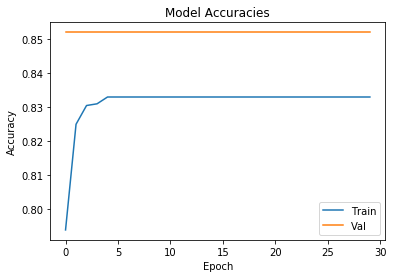

In [19]:
# Plot the history of this model
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

In [16]:
predictions = model.predict(x_val)

In [34]:
def checkAcc(predictions, truths):
    wrongs = 0
    for i,prediction in enumerate(predictions):
        truth = truths[i]
        for j, val in enumerate(prediction):
            if val >= 0.5 and truth[j] == 0:
                wrongs += 1
                # break
            if val < 0.5 and truth[j] == 1:
                wrongs += 1
                # break
    total = 41*len(predictions) # len(predictions)
    return (total - wrongs) / total, wrongs, total
                
            
checkAcc(predictions, y_val.values)

(0.8595, 11521, 82000)

In [29]:
y_val.values.shape

(2000, 41)